# Report : Deep Learning - Clone Driving Behavior
### Naaman Shmuel PhD

For this project, I build a neural network that will learn and close driving behavior. After training, the neural network will use to drive a car in a simulator. Toward that, I choose to use the outline of the AlexNet. This is a well-known network that is not very complex and can be trained in a reasonable short time. I modify the parameter setting of the model and make it simpler. The main idea was to make sure that the training will be possible on my machine considering the large training set needed. 

After I had a working network that is complex enough but on the other hand not too complex I start gathering data. I did find that the final parameter settings of the model can vary greatly but still the network will provide a good solution. The main point was gathering good training set. 

Training, I started with 8 Epochs but soon I find out that after the 6 epoch the performance improvement of the model is not significant, that is especially true when the training set increase.

In [1]:
#import matplotlib.pyplot as plt
import pandas as pd
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('driving_log.csv', header =None)

## Data Exploration 
### Images :
 * The upper 3/8 part of each image was crop. That allow the model to take as an input only the road and ignore the view that is not relevant for the driving. 
 * Each image was down sampled by 2. That allow more complex network ( in terms of memory) with out compremising about the results so much. 


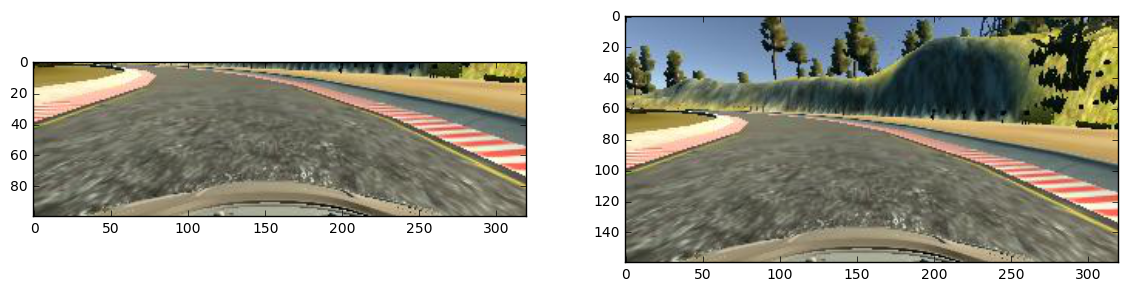

In [31]:
pylab.rcParams['figure.figsize'] = (14, 8)

img = mpimg.imread( df[0][1])
imshape = img.shape

crop_img = img[int(3*imshape[0]/8):imshape[0], 0:imshape[1],:]  

plt.subplot(1, 2, 1)
plt.imshow(crop_img)
plt.subplot(1, 2, 2)
plt.imshow( img)

Figure 1 : The images depict the input images on the left and the original image on the right. 

### Steering Angle :

* Let us examine the Steering Angle distribution using a Log scale Histogram 

count    39285.000000
mean        -0.048983
std          0.335034
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: 3, dtype: float64

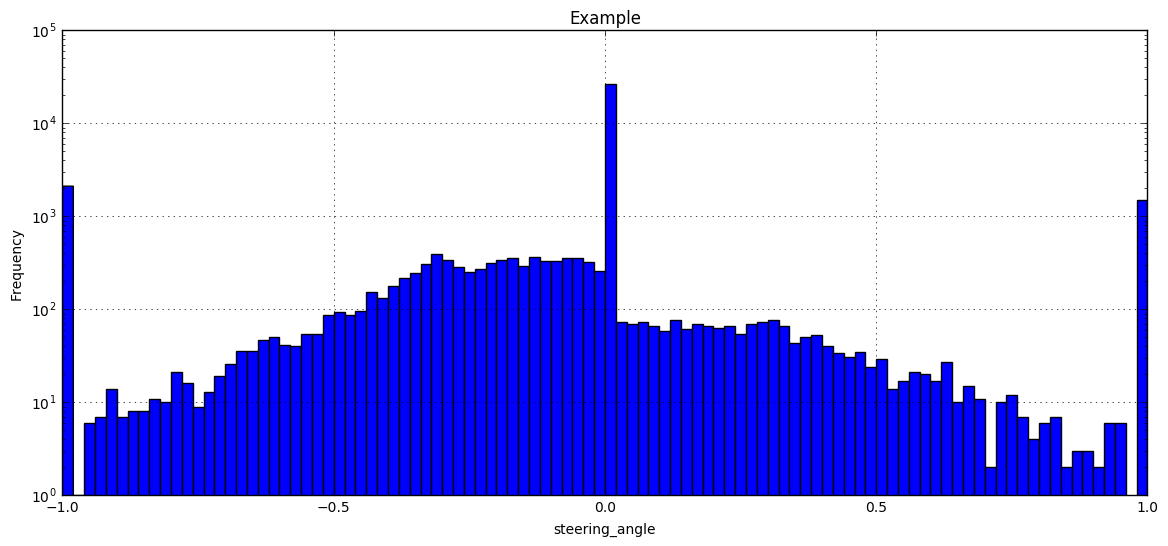

In [62]:
 pylab.rcParams['figure.figsize'] = (14, 6)
ax = df[3].hist(bins=100)
ax.set_ylabel('Frequency')
ax.set_xlabel('steering_angle')
ax.set_title('Example')
ax.set_yscale('log')
df[3].describe()
 

In [67]:
print ('Number of non zeros:',len(df[df[3]!=0]))
print ('Number of zeros:',len(df[df[3]==0]))

Number of non zeros 12619
Number of zeros 26666


Figure 2 : As can be seeing the zeros "Steering Angle" Frequency is larger than the other Steering Angle by at least 1 order of magnitude. Therefore we multiply the occurance of the non  zeros Steering Angle by 4. 

## Building the Network: Variation on AlexNet

### Help functions: Crop and downsample the images,  and read the data using a python generator

In [1]:
import csv
from scipy import misc
from sklearn.cross_validation import train_test_split
import cv2
import numpy as np

def region_of_interest (image):
    # A function that will use to crop the images befor feeding them to the model
    imshape = image.shape 
    crop_img = image[int(3*imshape[0]/8):imshape[0], 0:imshape[1],:]  

    return crop_img

def BatchGenerator():
    # A function that will use python generator to read the data. 
    # Aventually I did not had to cut the data since the machine I am using is strong enough. 
    
    X = []
    y = []
    # Open the file
    with open('driving_log.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', skipinitialspace=True)
        i = 0
        for row in reader:
            i += 1
            # setting the length of each batch that will be read from the file
            if(i % 40000 == 0):
                yield np.asarray(X), np.asarray(y)
                X = []
                y = []
            # ignore lines that include "RECORDING" 
            if("RECORDING" in row[0]):
                continue
            # The images are in column 0   of each row.
            img_center_filename = row[0]
            # Down sample the images by 2 
            img_center =  cv2.resize(misc.imread(img_center_filename)[:,:,:], (0,0), fx=0.5, fy=0.5)
            # Cut the upper part of the image
            img_center =region_of_interest( img_center)  
            # The target variable is in column 3 of each row. 
            steering_angle = float(row[3])
            # multiply images with stearing angle !=0
            num_samples = 1 
            if(steering_angle > 0):
                num_samples = 4 

            for j in range(num_samples):
                X.append(img_center)
                y.append(steering_angle)
    
    yield np.asarray(X), np.asarray(y)



## Network Training and validation

### Network Architecture 
 * The basic structure was based on AlexNet, 3 2-D convolution layers followed by 3 perceptron network. 
 * The first conv layer, 
   * Input shape : 50 X 160 X 3
   * Kernel dimenssion : 48 X 5 X 11, I set the dimenssion of the model with similar proportion of the images. 
   * This i layer use a **'linear'** activation. 
   * In this layer I also implement the **normalization**. that will make sure that the network will converage to the solution faster. 
   * The layer also use a **MaxPooling2D** of 4 X 4
 * The secound conv layer, 
   * Kernel dimenssion : 126 X 3 X 5 
   * This i layer use a **'linear'** activation. 
   * The layer also use a **MaxPooling2D** of 3 X 3
 * The third conv layer, 
   * Kernel dimenssion : 256 X 2 X 3  
   * This i layer use a **'ELU'** non linear activation. The idea was to set the non linearity on the largest layer. 
   * The layer also use a **MaxPooling2D** of 2 X 2
 * Flatening layer
 * The forth perceptron layer, 
   * Dimenssion : 512
   * This i layer use a **'linear'** activation. 
   * Drop out of 0.5 to reduce overfitting 
 * The fifth perceptron layer, 
   * Dimenssion : 256
   * This i layer use a **'linear'** activation. 
   * Drop out of 0.25 to reduce overfitting 
 * The fifth perceptron output layer, 
   * Dimenssion : 1
   * This i layer use a **'linear'** activation. 
#### Total params: 949087
 

In [3]:
#del model
from keras.models import Sequential
 
# TODO: Re-construct the network and add a pooling layer after the convolutional layer.
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation, Input, ELU
from keras.layers.normalization import BatchNormalization

from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
 
model = Sequential()

model.add(Conv2D(48, 5, 11, input_shape=(50, 160 ,3), activation='linear'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,4)))
 
model.add(Conv2D(126, 3, 5 , activation='linear'))
model.add(MaxPooling2D((3,3)))
 
model.add(Conv2D(256, 2, 3 ))
model.add(ELU())
model.add(MaxPooling2D((2,2)))
  
model.add(Flatten())

model.add(Dense(512, init='glorot_normal'))
model.add(Activation('linear'))
model.add(Dropout(0.5))

model.add(Dense(256, init='glorot_normal'))
model.add(Activation('linear'))
model.add(Dropout(0.25))

model.add(Dense(1, init='glorot_normal'))
model.add(Activation('linear'))

model.summary() 

model.compile(loss='mse',
              optimizer='adam' )
#history = model.fit(X_train, y_train,
#                    batch_size=80, nb_epoch=5,
#                    verbose=1, validation_data=(X_val, y_val))
for X, y in BatchGenerator():
    X_train, X_val, y_train, y_val = train_test_split(X, y , random_state=5, test_size=0.1)

    history = model.fit(X_train, y_train,
                    batch_size=80, nb_epoch=6,
                    verbose=1, validation_data=(X_val, y_val))


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 46, 150, 48)   7968        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 46, 150, 48)   96          convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 11, 37, 48)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 9, 33, 126)    90846       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [4]:
import json
model.save_weights("./model.h5")
with open ('./model.json','w') as outfile :

    json.dump(model.to_json(),outfile)


## Training / Validation / Testing

#### For the training I use 40 K images obtained from the simulator. As the first base I use 10k images, I trained and validate the model. The Next step I use iteration to correct specific mistakes that the agent had. I was running the model, and wait for the agent to run out of the road. I then include a correction for the agent that specifically addressed the mistake that was done. I repeat that few times till the agent stays on the road for one cycle.

#### The model use loss function for the 'mse' since this is a regression problem and 'adam' optimizer that save us the troubles for looking  after the correct learning rate. 